# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./demo04_breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform binary classification, and evaluating performance using various metrics
* Perform multi-class logistic classification, and evaluating performance using accuracy and confusion matrix
* Use L1-regularization to promote sparse weights for improved estimation (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
# TODO
# df = ...
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',
                index_col = 0)
df.head(6)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
# TODO
# df1 = ...
df1 = df.fillna(df.mean())

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [4]:
# TODO
# y = ...
y = np.unique(df1['Genotype'].values, return_inverse=True)[1]
print(y.shape)

(1080,)


As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [5]:
# TODO
# Xs = ...
attributes = df.columns.tolist()
xnames = attributes[:(len(attributes)-4)]
Xs = np.array(df1[xnames])
print(Xs.shape)

(1080, 77)


Create a `LogisticRegression` object `logreg` and `fit` the training data. Use `C = 1e5`.

In [6]:
# TODO
logreg = linear_model.LogisticRegression(C = 1e5)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of time that the predictions match the true labels. Also, plot the ROC curve, and measure the AUC. Later, we will properly measure the accuracy and AUC on cross-validation data.

In [7]:
# TODO
from sklearn.metrics import precision_recall_fscore_support

yhat = logreg.predict(Xs)

# Measure performance
prec,rec,f1,_= precision_recall_fscore_support(y,yhat,average='binary') 

acc = np.mean(yhat == y)

print('Precision = {0:.4f}'.format(prec))
print('Recall    = {0:.4f}'.format(rec))
print('f1        = {0:.4f}'.format(f1))
print('Accuracy  = {0:.4f}'.format(acc))

Precision = 1.0000
Recall    = 1.0000
f1        = 1.0000
Accuracy  = 1.0000


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

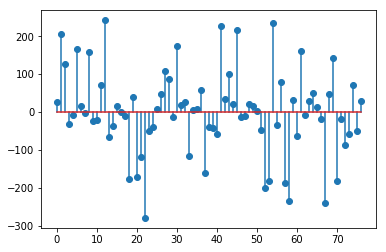

In [8]:
# TODO
w = (np.array(logreg.coef_)).T
n = [n for n in range(0,len(w))]
plt.stem(n,w)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [9]:
# TODO
Isel = np.argsort(w,axis=0)
I_largest2 = Isel[(len(w)-2):]

I1 = int(I_largest2[1])
I2 = int(I_largest2[0])
print(xnames[I1], xnames[I2])

PKCA_N ERBB4_N


## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall and f1-score, as well as the AUC.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [10]:
# TODO
import  sklearn.model_selection 

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

prec = []
rec = []
f1 = []
acc = []

# Loop over the folds
for isplit, Ind in enumerate(kf.split(Xs)):
    
    Itr, Its = Ind
    
    xtr = Xs[Itr]
    ytr = y[Itr]
    xts = Xs[Its]
    yts = y[Its]
    
    logreg.fit(xtr,ytr) # Create predicted data and compare
        
    # Measure RSS on test data
    yts_hat = logreg.predict(xts)
     
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yts_hat) 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yts_hat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

print('Precision = {0:.4f}'.format(precm))
print('Recall =    {0:.4f}'.format(recm))
print('f1 =        {0:.4f}'.format(f1m))
print('Accuracy =  {0:.4f}'.format(accm))

Precision = 0.9589
Recall =    0.9593
f1 =        0.9589
Accuracy =  0.9593


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7. 

In [11]:
# TODO
# y = ...
y = np.unique(df1['class'].values, return_inverse=True)[1]
print(len(y))

1080


Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method. In general, you could either use the 'one over rest (ovr)' option or the 'multinomial' option. In this exercise use the default 'ovr' and `C=1`. As an optional exercise, you could also compare the results obtained with these two options. 

In [12]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy on the training data.

In [13]:
# TODO
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 1.000000


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

Nclass = 8
C = np.zeros((Nclass,Nclass))
C_norm = np.zeros((Nclass,Nclass))

# Loop over the folds
accuracy = np.zeros(nfold)
for Itr, Its in kf.split(Xs,y):
    
    xtr = Xs[Itr,:]
    ytr = y[Itr]
    xts = Xs[Its,:]
    yts = y[Its]
    
    logreg.fit(xtr,ytr) # Create predicted data and compare
        
    # Measure RSS on test data
    yts_hat = logreg.predict(xts)
     
    C += confusion_matrix(yts,yts_hat)
    
print(np.array_str(C, precision=4, suppress_small=True))

for n in range(0,len(C)):
    C_norm[n,:] = C[n,:] / np.sum(C[n,:])
print('\n')
print(np.array_str(C_norm, precision=4, suppress_small=True))

[[147.   2.   0.   0.   1.   0.   0.   0.]
 [  3. 129.   0.   0.   2.   1.   0.   0.]
 [  0.   0. 150.   0.   0.   0.   0.   0.]
 [  1.   0.   0. 134.   0.   0.   0.   0.]
 [  1.   1.   0.   0. 133.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 105.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 135.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 135.]]


[[0.98   0.0133 0.     0.     0.0067 0.     0.     0.    ]
 [0.0222 0.9556 0.     0.     0.0148 0.0074 0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.0074 0.     0.     0.9926 0.     0.     0.     0.    ]
 [0.0074 0.0074 0.     0.     0.9852 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes for the first class.

<StemContainer object of 3 artists>

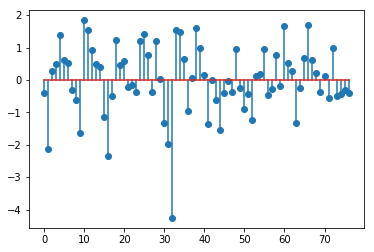

In [15]:
# TODO
logreg = linear_model.LogisticRegression()
logreg.fit(Xs, y)
yhat = logreg.predict(Xs)

w = (np.array(logreg.coef_)).T
n = [m for m in range(0,len(w))]

plt.stem(n,w[:,0])

## L1-Regularization

Graduate students only complete this section.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../unit03_model_sel/demo03_2_prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you to find a good range.
* For each C and each fold, you should compute the classification error rate 
* For each C and each fold, you should also determine the nubmer of non-zero coefficients for the first class. For this purpse, you can assume coefficient with magnitude <0.01 as zero.

In [16]:
# TODO

Now compute the mean and standard error on the error rate for each `C` and plot the results (Use `errorbar()` method).  Also determine and print the minimum test error rate and corresponding C value. 

In [17]:
# TODO

We see that the minimum error rate is significantly below the classifier that did not use the l1-penalty.  Use the one-standard error rule to determine the optimal `C` and the corresponding test error rate. Note that because `C` is inversely proportional to the regularization strength, you want to select a `C` as *small* as possible while meeting the error target!

In [18]:
# TODO
# C_opt = 

**Question:** How does the test error rate compare with the classifier that did not use the l1-penalty? Explain why.

**Type Answer Here:**


Now plot the nubmer of non-zero coefficients for the first class for different C values. Also determine and print the number of non-zero coefficients corresponding to C_opt.

In [19]:
# TODO

For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible. Please also compare the accuracy for the training data using optimal `C` with the previous results not using LASSO regularization. Do you expect the accuracy to improve?

In [20]:
# TODO